## xgboost results

This notebook contains the results from xgboost.

- XGBoost was first optmized with a very small grid (trees and learning rate)
- afterwards the selected features were used within a larger grid search space

We want to have the following results:
1. Results of the cross-validation
2. Results of the train / test split
3. SHAP results
4. interactions
5. target / decoys

Methods:
TBD

In [145]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import shap
shap.initjs()
data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_CO_NAVG_small.p", "rb"))
#data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_OH_AVG_tiny.p", "rb"))

data_dic.keys()
#dict_keys(['best_features_gs', 'summary_gs', 'best_params_gs', 'xifaims_params', 'xifaims_config', 'xgb', 'predictions_df', 'data', 'metrics', 'df_unique', 'df_nonunique'])

dict_keys(['best_features_gs', 'summary_gs', 'best_params_gs', 'xifaims_params', 'xifaims_config', 'xgb', 'predictions_df', 'data', 'metrics', 'df_unique', 'df_nonunique'])

## Train-Test Split

The following table summarizes the metrics for training on 80% of the data and then predicting on the other 20%.


In [146]:
metrics_df = data_dic["metrics"]
metrics_df = metrics_df.round(2)
metrics_df = metrics_df.set_index("split")
metrics_df

,r2,pearsonr,MAE,MSE
split,,,,
Train,0.81,0.91,3.67,23.35
Validation,0.54,0.74,5.83,57.56
DX,0.41,0.66,5.59,49.46


## Best features:

Using mlxtend and the nested SequentialFeatureSelector + GridSearch the following features get choosen through a parsimony criterium:

In [161]:
features = data_dic["best_features_gs"]
print(features)

print(data_dic["best_params_gs"])

Index(['charge_3', 'charge_5', 'charge_8', 'aromatics', 'charge_density',
       'intrinsic_size_sum', 'intrinsic_size_max', 'mv_sum', 'mv_size_std',
       'mv_size_max', 'polarity_size_std', 'polarity_size_max',
       'secondstruc_size_max', 'static_size_max', 'm/z'],
      dtype='object')
{'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 50, 'nthread': 1, 'seed': 42, 'subsample': 0.9}


# Cross-validation results

The CV was done using 3splits and negative_mean_squared_error as metric.

In [148]:
df_cv = data_dic["summary_gs"]
df_cv = df_cv.sort_values("rank_test_score", ascending=True)
print(df_cv.head())
best_cv = df_cv
best_cv
#print(best_cv)
best_df = df_cv.filter(regex="split|rank")
best_df


    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
33    1225.934207     53.390027         0.023669        0.000444   
28    1227.799316     46.769655         0.026671        0.000301   
25    1229.013179     22.104078         0.026939        0.000193   
29    1222.427076     54.907009         0.043458        0.009404   
26    1202.455504     50.573412         0.036332        0.005655   

   param_xgb__colsample_bytree param_xgb__gamma param_xgb__learning_rate  \
33                         0.8                0                      0.1   
28                         0.8                0                      0.1   
25                         0.8                0                      0.1   
29                         0.8                0                      0.1   
26                         0.8                0                      0.1   

   param_xgb__max_depth param_xgb__min_child_weight param_xgb__n_estimators  \
33                    9                           3    

,split0_test_score,split1_test_score,split2_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score
33,-61.605171,-59.645498,-60.144199,1,-13.087515,-14.697182,-12.352541
28,-61.343043,-59.863254,-60.785056,2,-18.544850,-19.606460,-17.576342
25,-60.865635,-61.087273,-60.168789,3,-17.294324,-18.163073,-16.860168
29,-61.752898,-59.573694,-61.588380,4,-11.726271,-12.900937,-11.761886
26,-61.368983,-60.870783,-60.831312,5,-11.559091,-11.973420,-10.692492
...,...,...,...,...,...,...,...
0,-955.089427,-965.911347,-983.099048,104,-972.093514,-969.290352,-959.580976
60,-953.692250,-967.903523,-982.518389,105,-968.755608,-963.631408,-955.200204
3,-955.181204,-965.892763,-983.064486,106,-972.128734,-969.296143,-959.596793
12,-954.898795,-968.554935,-981.963100,107,-969.114909,-964.530766,-955.505074


In [149]:
res_melt = best_df.melt(id_vars=["rank_test_score"])
res_melt = res_melt[res_melt["rank_test_score"] == 1]
res_melt["Split"] = ["Train" if "train" in i else "Test" for i in res_melt["variable"]]
res_melt



,rank_test_score,variable,value,Split
0,1,split0_test_score,-61.605171,Test
108,1,split1_test_score,-59.645498,Test
216,1,split2_test_score,-60.144199,Test
324,1,split0_train_score,-13.087515,Train
432,1,split1_train_score,-14.697182,Train
540,1,split2_train_score,-12.352541,Train


## Train - Validation Evaluation

Evaluate the results when the model was trained on 80%.

In [150]:
predictions_df = data_dic["predictions_df"]
predictions_df.Split.unique()
predictions_df["Split"] = predictions_df["Split"].str.replace("Test", "Validation")
predictions_df
predictions_df["diff"] = predictions_df["predictions"] -  predictions_df["observed"]
predictions_df["diff_abs"] = np.abs(predictions_df["predictions"] -  predictions_df["observed"])
predictions_df["Split"] = [f"{i} ({metrics_df.loc[i]['pearsonr']})" for i in predictions_df["Split"]]
predictions_df.head()



,predictions,observed,Split,diff,diff_abs
0,-58.920406,-63.794348,Train (0.91),4.873942,4.873942
1,-42.200878,-39.828690,Train (0.91),-2.372189,2.372189
2,-35.734035,-34.884130,Train (0.91),-0.849906,0.849906
3,-35.940552,-28.852063,Train (0.91),-7.088489,7.088489
4,-42.827896,-40.007617,Train (0.91),-2.820279,2.820279


<AxesSubplot:xlabel='Split', ylabel='diff'>

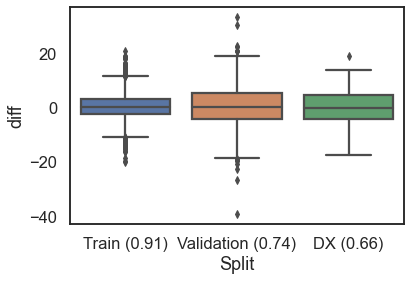

In [151]:
sns.boxplot(x="Split", y="diff", data=predictions_df)

<AxesSubplot:xlabel='Split', ylabel='diff_abs'>

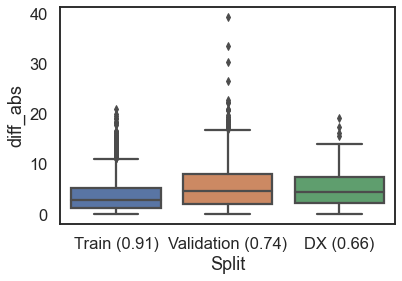

In [152]:
sns.boxplot(x="Split", y="diff_abs", data=predictions_df)

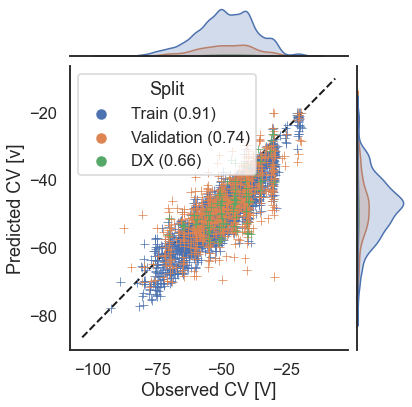

In [153]:
#fax = sns.jointplot(y="predictions", x="observed", hue="Split", data=predictions_df[predictions_df["Split"] != "DX"], marker="+", s=50)
fax = sns.jointplot(y="predictions", x="observed", hue="Split", data=predictions_df, marker="+", s=80)
fax.ax_joint.set(xlabel="Observed CV [V]", ylabel="Predicted CV [v]")
x0, x1 = fax.ax_joint.get_xlim()
y0, y1 = fax.ax_joint.get_ylim()
fax.ax_joint.plot([x0, x1], [y0, y1], ls="--", zorder=-1, lw=2, c="k")



### SHAP Analysis
Use shap to determine:
1. most important parameters
2. interesting interactions

In [154]:
print("Loading model, train, val, dx features and best features")
# model
model = data_dic["xgb"]
print(data_dic["data"].keys())

# data consists of tuples with meta data and feature data
all_data = data_dic["data"]
TT_train, TT_train_features = all_data["TT_train"] 
TT_val, TT_val_features = all_data["TT_val"] 
DX = all_data["DX"] 
#print(all_data)

# use shortcut
X = TT_val_features[features]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_values_inter = shap.TreeExplainer(model).shap_interaction_values(X)

Loading model, train, val, dx features and best features
dict_keys(['TT_train', 'TT_val', 'DX'])


<AxesSubplot:xlabel='SHAP value (impact on model output)'>

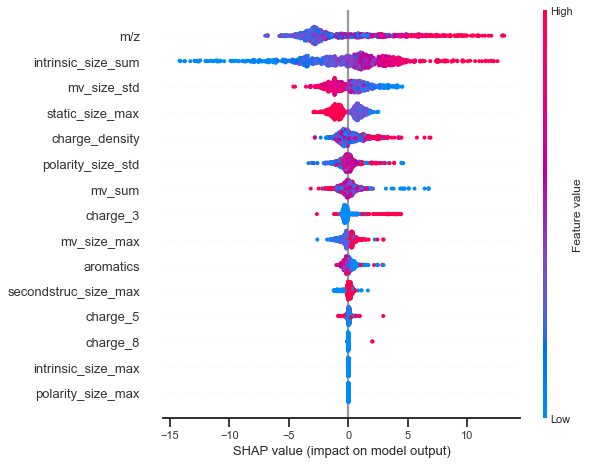

In [155]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, show=False)
fig = plt.gcf()
ax = plt.gca()
ax

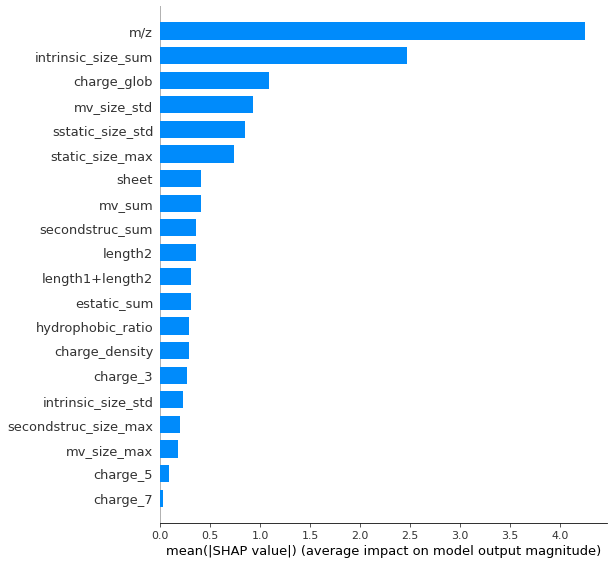

In [15]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [16]:
# shap viz
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [17]:
shap.force_plot(explainer.expected_value, shap_values, X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


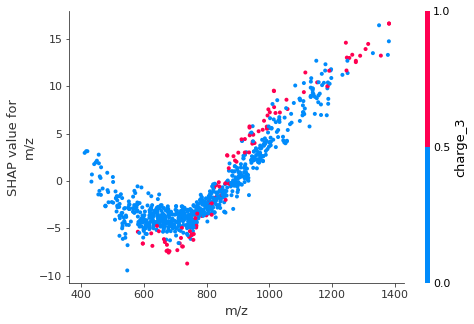

In [91]:
shap.dependence_plot("m/z", shap_values, X)

## Final Figure


In [158]:
res_melt

,rank_test_score,variable,value,Split
0,1,split0_test_score,-61.605171,Test
108,1,split1_test_score,-59.645498,Test
216,1,split2_test_score,-60.144199,Test
324,1,split0_train_score,-13.087515,Train
432,1,split1_train_score,-14.697182,Train
540,1,split2_train_score,-12.352541,Train


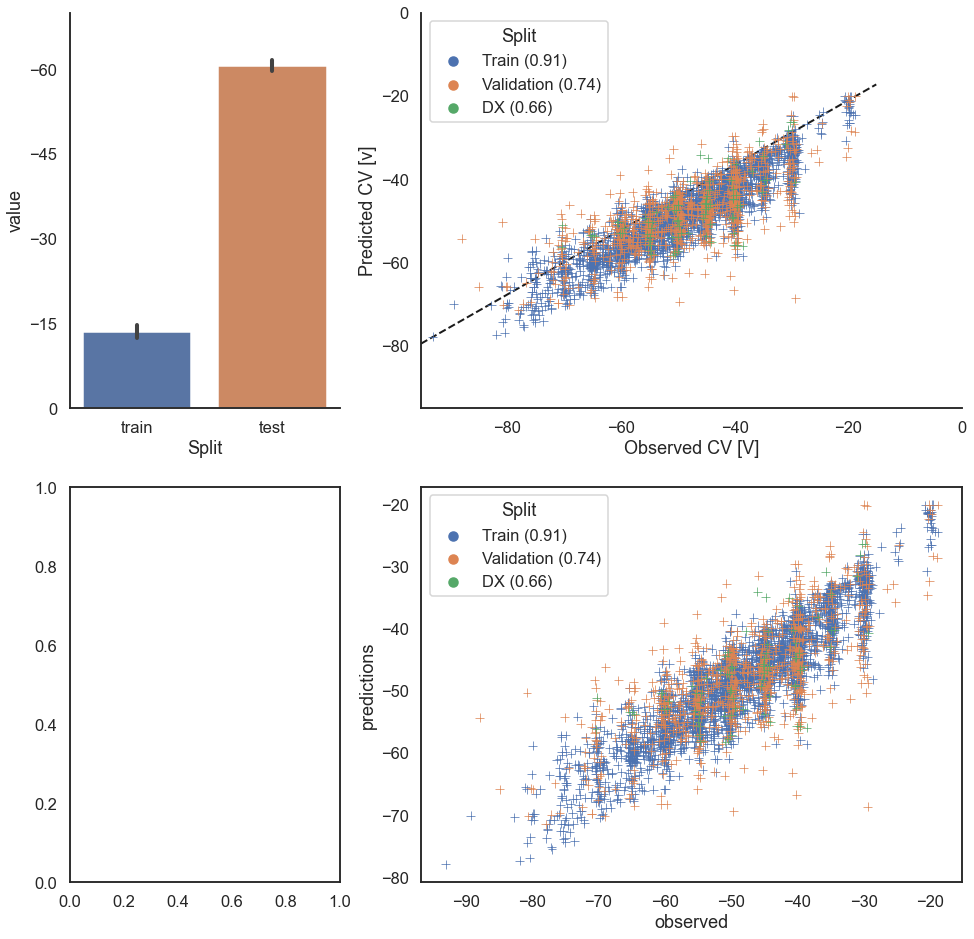

In [160]:
from matplotlib import ticker
sns.set(style="white", context="talk")
gridspec_kw={'width_ratios':[0.5, 1]}
f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 16), gridspec_kw=gridspec_kw)

# bar plot
ax0 = sns.barplot(x="Split", y="value", data=res_melt, ax=ax0, order=["Train", "Test"])
ax0.set_ylim(0, -70)
ax0.set(xlabel="XGBoost", ylabel="neg. mean squared error")
ax0.yaxis.set_major_locator(ticker.MaxNLocator(5))
sns.despine(ax=ax0)

ax1 = sns.scatterplot(y="predictions", x="observed", hue="Split", data=predictions_df, marker="+", s=80, ax=ax1)
x0, x1 = ax1.get_xlim()
y0, y1 = ax1.get_ylim()
ax1.plot([x0, x1], [y0, y1], ls="--", zorder=-1, lw=2, c="k")
ax1.set(xlabel="Observed CV [V]", ylabel="Predicted CV [v]")
ax1.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax1.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax1.set(xlim=(-95, 0), ylim=(-95, 0))
sns.despine(ax=ax1)


ax2 = sns.barplot(x="Split", y="value", data=res_melt, ax=ax0, order=["train", "test"])
ax3 = sns.scatterplot(y="predictions", x="observed", hue="Split", data=predictions_df, marker="+", s=80, ax=ax3)


In [ ]:
#%%
# retrieve the shap plot from above
shap.summary_plot(shap_values, X, show=False)
_ = plt.gcf()
_.ax
#ax4 = plt.gca()

shap.dependence_plot("m/z", shap_values, X, show=False)
ax3 = plt.gca()
